In [1]:
from jupyter_tikz import TexFragment
import os, sys
from IPython.display import display, HTML, Markdown, Math

sys.path.append('../src')

from pmule import PredecessorTable, ProjectGraph, pinta_tikz

In [2]:
%%capture
%mkdir -p ~/temp
%cd ~/temp

# Enunciado

Considere el proyecto cuya información se adjunta.  

In [3]:
periodo_probabilidad_b = 12

pregunta_1 = "1.  Dibuje el diagrama Pert y determine el camino crítico.  "
pregunta_2 = "2.  Indique el coste de realización para duración PERT  "
pregunta_3 = f"3.  A la vista de la planificación dada, su jefe le dice que el proyeco tiene que ejecutarse en {periodo_probabilidad_b} o menos periodos. ¿Con qué probabilidad estima que se verán cumplidos los deseos de su jefe?  "
pregunta_4 = "4.  Reduzca la duración del proyecto dos unidades de tiempo con el menor incremento de coste posible.  "

In [4]:
display(Markdown(pregunta_1))
display(Markdown(pregunta_2))
display(Markdown(pregunta_3))
display(Markdown(pregunta_4))

1.  Dibuje el diagrama Pert y determine el camino crítico.  

2.  Indique el coste de realización para duración PERT  

3.  A la vista de la planificación dada, su jefe le dice que el proyeco tiene que ejecutarse en 12 o menos periodos. ¿Con qué probabilidad estima que se verán cumplidos los deseos de su jefe?  

4.  Reduzca la duración del proyecto dos unidades de tiempo con el menor incremento de coste posible.  

In [5]:
import pandas as pd
import numpy as np

datos_enunciado = pd.DataFrame([
#  actividad, precedentes, b, m, a, coste_duracion_pert, coste_duracion_tope, duracion_tope
     ('A', '---  ',   6,  2.5, 2, 1600, 1800, 2),
     ('B', '---  ',   2,    2, 2, 2900, 2900, 1),
     ('C', '---  ',   1,    1, 1,  600,  600, 1),
     ('D', '---  ',   1,    1, 1,  600,  600, 1),
     ('E', 'A,B  ',  12,    5, 4, 1600, 2200, 2),
     ('F', 'A,B  ',  12,  2.5, 2, 2000, 2200, 1),
     ('G', 'B,C  ',   6, 1.25, 1,  600,  700, 1),
     ('H', 'B,C  ',  20,   13, 6, 3500, 4900, 3),
     ('I', 'D    ',  30,   12, 6, 3500, 4300, 4),
     ('J', 'E,M  ',   4,    4, 4, 1500, 1500, 2),
     ('K', 'F    ',   7,    7, 7, 2000, 2000, 3),
     ('L', 'J,K,G',   1,    1, 1, 1000, 1000, 1),
     ('M', 'F    ',   3,    3, 3,  500,  500, 1),

] ,columns=['activity', 'predecessors', 'b', 'm', 'a',
            'cost_pert_duration', 'cost_cap_duration', 'cap_duration']).set_index('activity')

datos_enunciado['b'] = datos_enunciado['b'].astype(int)
datos_enunciado

,predecessors,b,m,a,cost_pert_duration,cost_cap_duration,cap_duration
activity,,,,,,,
A,---,6,2.50,2,1600,1800,2
B,---,2,2.00,2,2900,2900,1
C,---,1,1.00,1,600,600,1
D,---,1,1.00,1,600,600,1
E,"A,B",12,5.00,4,1600,2200,2
F,"A,B",12,2.50,2,2000,2200,1
G,"B,C",6,1.25,1,600,700,1
H,"B,C",20,13.00,6,3500,4900,3
I,D,30,12.00,6,3500,4300,4


{{< pagebreak >}}

# Solución
## Apartado 1

In [6]:
display(Markdown(pregunta_1))

1.  Dibuje el diagrama Pert y determine el camino crítico.  

### Cuadro de prelaciones expandido

Comenzamos construyendo el cuadro de prelaciones. Este cuadro nos permitirá construir los grafos Pert o Roy, si atendemos a la información de las filas; o comprobar si el grafo obtenido es correcto, atendiendo a la información de las columnas.


In [7]:
#| tbl-cap: "Cuadro de prelaciones expandido"
#| label: tbl-prelaciones
datos_proyecto = datos_enunciado.copy()
prelaciones = PredecessorTable.from_dataframe_of_strings(datos_proyecto, activity='activity', predecessor='predecessors')
prelaciones.display_immediate_linkage_matrix()

,A,B,C,D,E,F,G,H,I,J,K,L,M
activities,,,,,,,,,,,,,
A,,,,,,,,,,,,,
B,,,,,,,,,,,,,
C,,,,,,,,,,,,,
D,,,,,,,,,,,,,
E,True,True,,,,,,,,,,,
F,True,True,,,,,,,,,,,
G,,True,True,,,,,,,,,,
H,,True,True,,,,,,,,,,
I,,,,True,,,,,,,,,


### Precálculo de variables de interés

A partir de los datos del enunciado podemos calcular la duración media, la desviación típica y el coste unitario de reducción que utilizaremos para contestar las preguntas realizadas.

In [8]:
display(Math(r"$duration=\frac{a+4m+b}{6}$"))
display(Math(r"$standard ~ deviation=\frac{b-a}{6}$"))
display(Math(r"$ucr=\frac{C_{cap}-C_{pert}}{d_{cap}-d_{pert}}$"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

{{< pagebreak >}}

In [9]:
datos_proyecto['duration'] = datos_proyecto.eval('(b + 4*m +a)/6')
datos_proyecto['standard_deviation'] = datos_proyecto.eval('(b -a)/6').round(2)
datos_proyecto['ucr'] = datos_proyecto.eval('(cost_cap_duration - cost_pert_duration)/(duration - cap_duration)').round(2)

In [10]:
#| tbl-cap: "Duración y desviación típica de las actividades calculadas"
#| label: tbl-datosInteresantes
datos_proyecto[['b', 'm', 'a', 'duration', 'standard_deviation', 'ucr']]

,b,m,a,duration,standard_deviation,ucr
activity,,,,,,
A,6,2.50,2,3.0,0.67,200.00
B,2,2.00,2,2.0,0.00,0.00
C,1,1.00,1,1.0,0.00,NaN
D,1,1.00,1,1.0,0.00,NaN
E,12,5.00,4,6.0,1.33,150.00
F,12,2.50,2,4.0,1.67,66.67
G,6,1.25,1,2.0,0.83,100.00
H,20,13.00,6,13.0,2.33,140.00
I,30,12.00,6,14.0,4.00,80.00


### Grafo PERT con numeración de nodos
Utilizando el cuadro de prelaciones expandido podemos dibujar el grafo Pert correspondiente al proyecto.

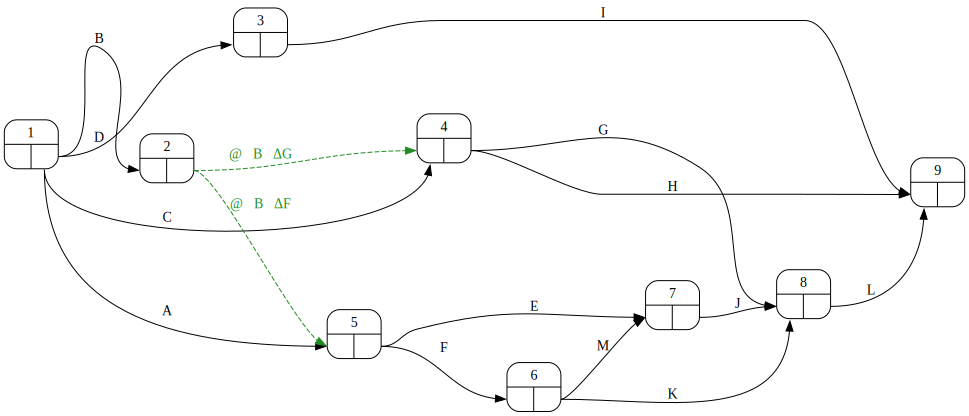

In [11]:
#| fig-cap: "Grafo Pert con indicación con indicación de los números de nodos"
#| label: fig-pertNumeracionNodos
proyecto = prelaciones.create_project()
proyecto.pert(ranksep=1, nodesep=0.6)

Alternativamente podríamos haber representado su grafo Roy.

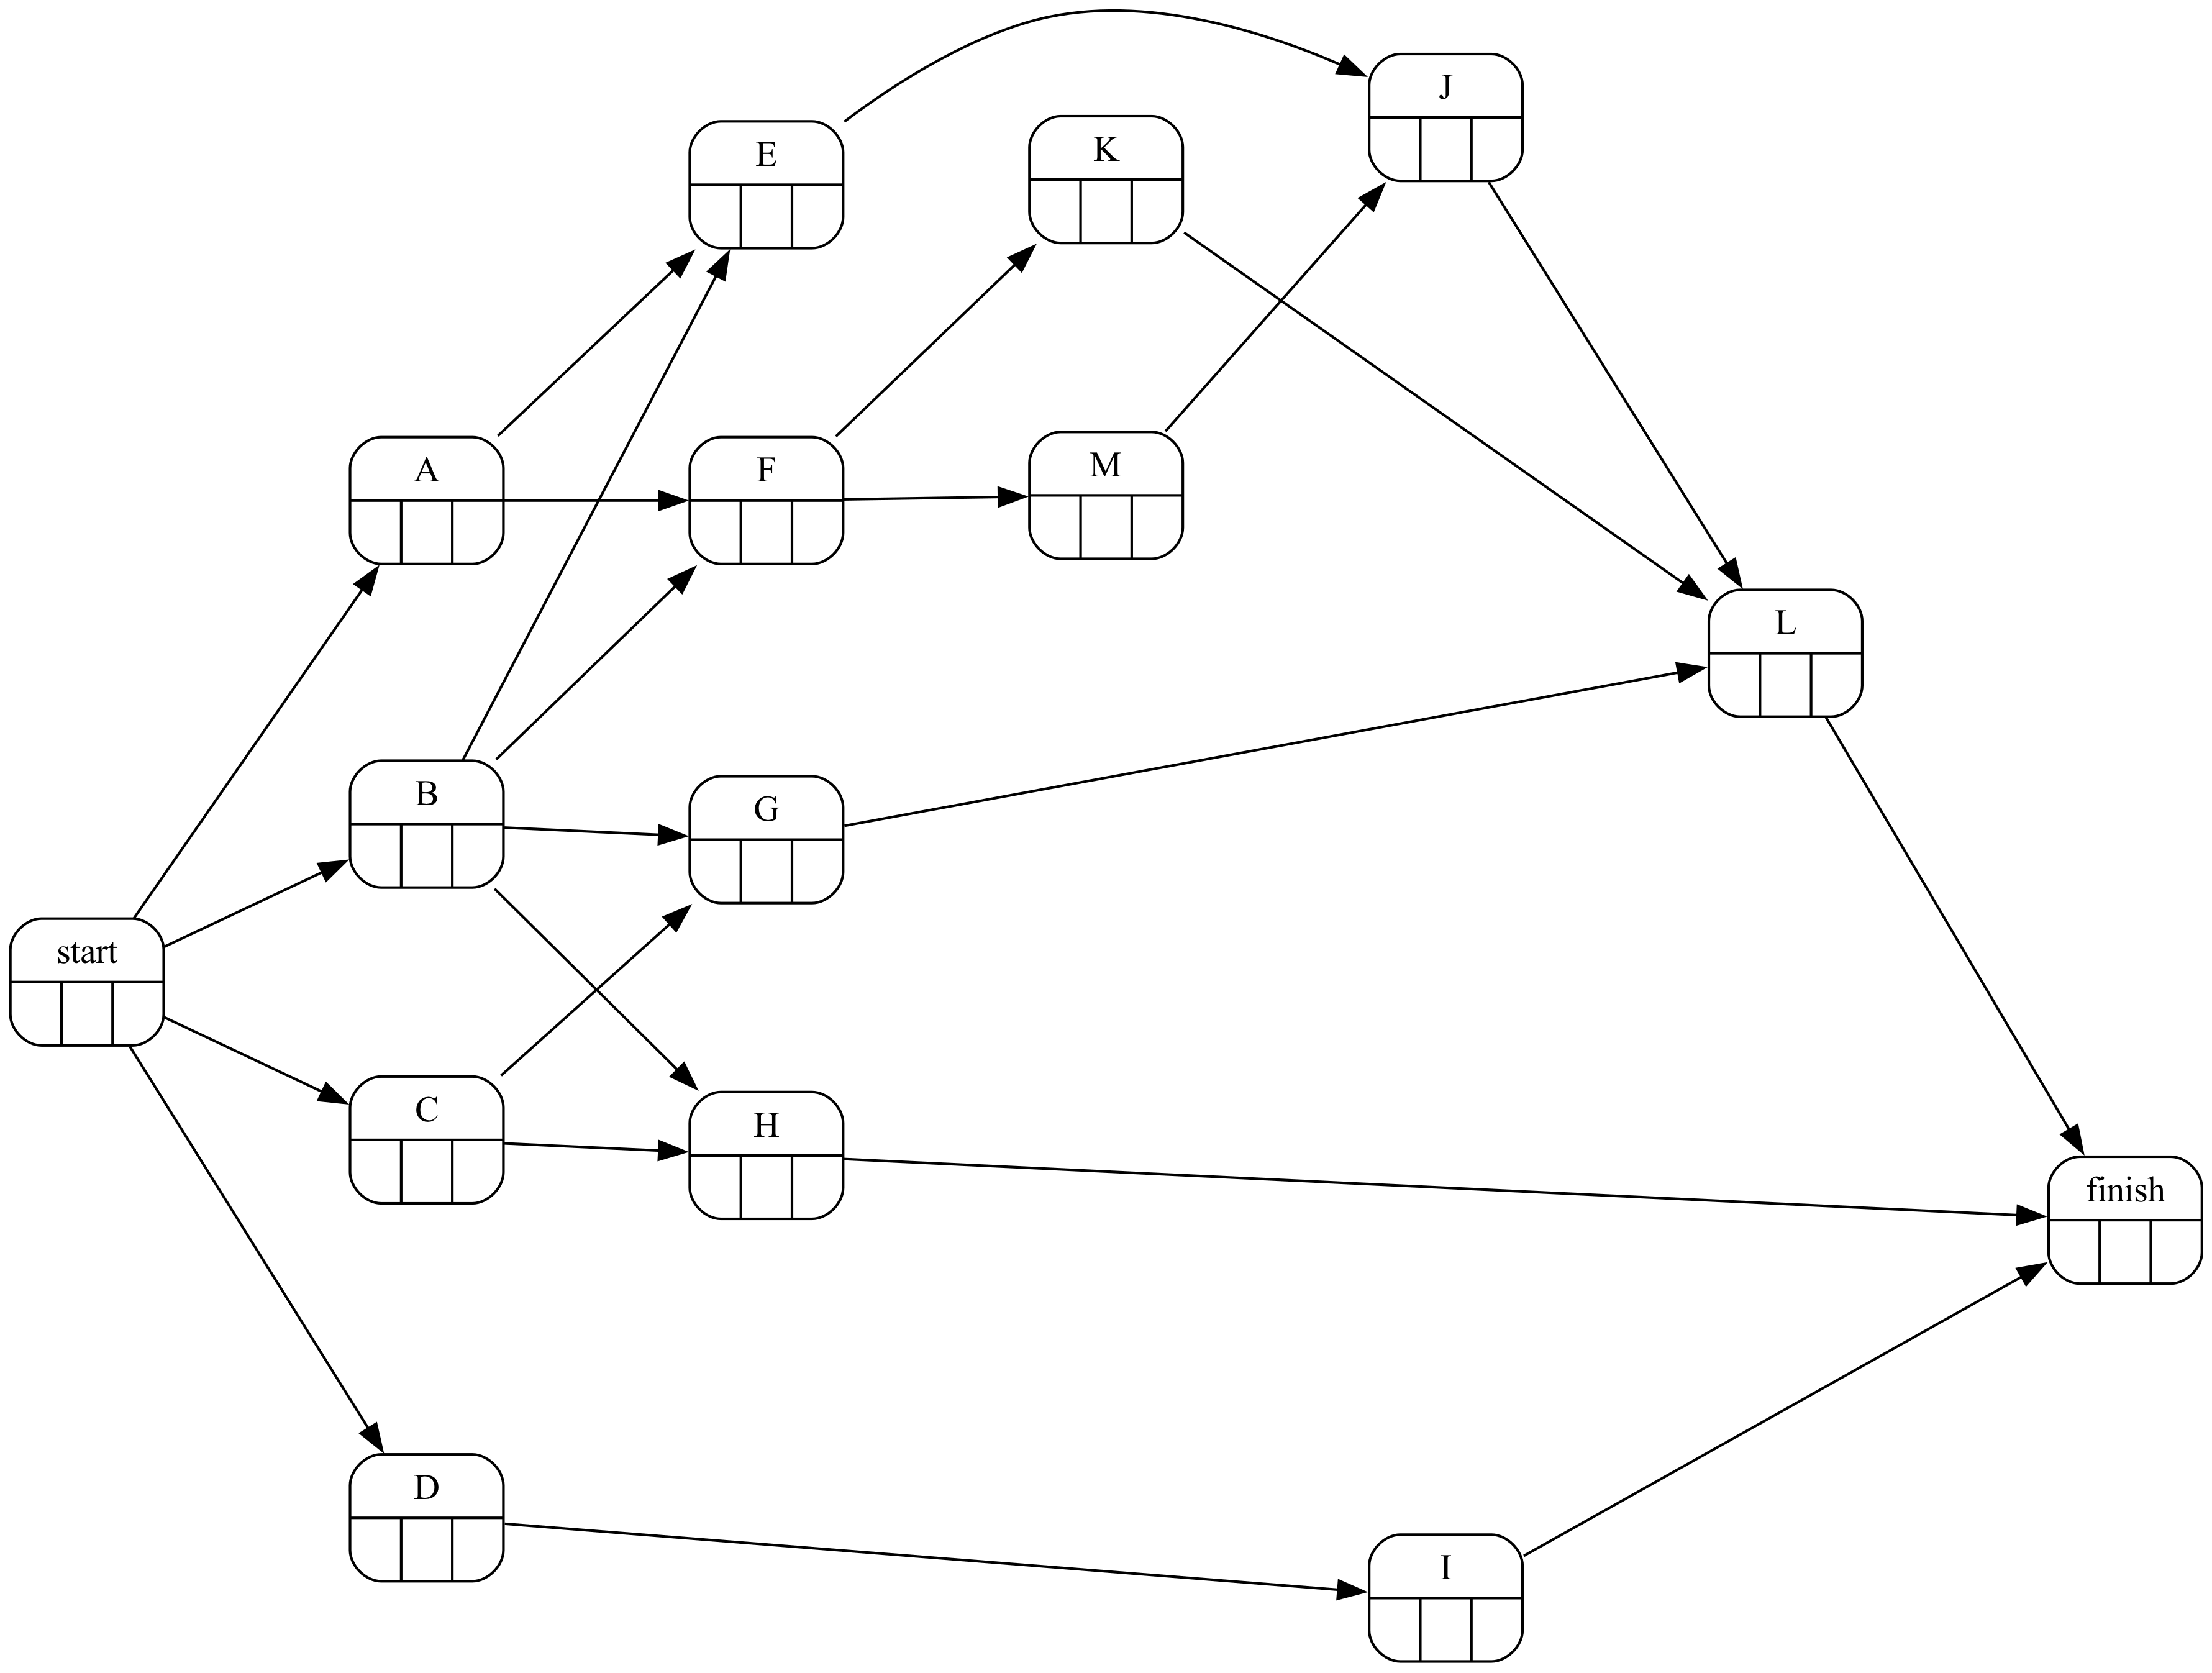

In [12]:
#| fig-cap: "Grafo Roy del proyecto"
#| label: fig-roy
proyecto.roy(ranksep=1, nodesep=1)

### Matriz de Zaderenko
A continuación podemos determinar la duración del proyecto calculando los tiempos tempranos y tardíos de su grafo Pert. Se hace en este caso mediante el algoritmo de Zaderenko:

In [13]:
#| tbl-cap: "Matriz de Zaderenko para el cálculo de tiempos tempranos y tardíos"
#| label: tbl-Zaderenko
proyecto.zaderenko(datos_proyecto['duration'])

,1,2,3,4,5,6,7,8,9,early
1,,2.0,1.0,1.0,3.0,,,,,0.0
2,,,,0.0,0.0,,,,,2.0
3,,,,,,,,,14.0,1.0
4,,,,,,,,2.0,13.0,2.0
5,,,,,,4.0,6.0,,,3.0
6,,,,,,,3.0,7.0,,7.0
7,,,,,,,,4.0,,10.0
8,,,,,,,,,1.0,14.0
9,,,,,,,,,,15.0
late,0.0,2.0,1.0,2.0,3.0,7.0,10.0,14.0,15.0,


Los tiempos tempranos y tardíos obtenidos para cada nodo son:

In [14]:
resultados_pert = proyecto.calculate_pert(datos_proyecto['duration'])
resultados_pert['nodes']

,early,late
1,0,0
2,2,2
3,1,1
4,2,2
5,3,3
6,7,7
7,10,10
8,14,14
9,15,15


### Duración media del proyecto

In [15]:
duracion_media_proyecto = int(float(proyecto.duration(datos_proyecto['duration'])))
Markdown(f"De acuerdo a la duración obtenida para el nodo final del proyecto, la duración media del proyecto es {duracion_media_proyecto} periodos.")

De acuerdo a la duración obtenida para el nodo final del proyecto, la duración media del proyecto es 15 periodos.

### Calendario del proyecto
Las fechas de inicio y fin más tempranas y tardías de cada actividad son:

In [16]:
#| tbl-cap: "Calendario del proyecto"
#| label: tbl-calendario
calendario = proyecto.calendar(datos_proyecto['duration'])
calendario

,inicio_mas_temprano,inicio_mas_tardio,fin_mas_temprano,fin_mas_tardio,H_total,duracion
activity,,,,,,
A,0,0,3,3,0,3.0
B,0,0,2,2,0,2.0
C,0,1,1,2,1,1.0
D,0,0,1,1,0,1.0
E,3,4,9,10,1,6.0
F,3,3,7,7,0,4.0
G,2,12,4,14,10,2.0
H,2,2,15,15,0,13.0
I,1,1,15,15,0,14.0


### Holgura total de las actividades
De acuerdo a los cálculos realizados, la holgura total de las actividades es:

In [17]:
#| tbl-cap: "Holgura total de las actividades"
#| label: tbl-holguras
resultados_pert['activities']

,H_total
@∇B⤑ΔF,1
@∇B⤑ΔG,0
A,0
B,0
C,1
D,0
E,1
F,0
G,10
H,0


### Camino crítico
Las actividades con holgura total cero forman el camino crítico. Según el grafo Pert del proyecto, éste está compuesto por las siguientes rutas, cuyas actividades se listan en orden alfabético:

In [18]:
camino_critico = proyecto.critical_path(datos_proyecto['duration'])
proyecto.display_critical_path(datos_proyecto['duration'])

- Route_2 :	A, F, K, L <br> 

- Route_3 :	A, F, J, L, M <br> 

- Route_8 :	B, H <br> 

- Route_11 :	D, I <br> 

##### Grafo PERT con indicación de tiempos y camino crítico

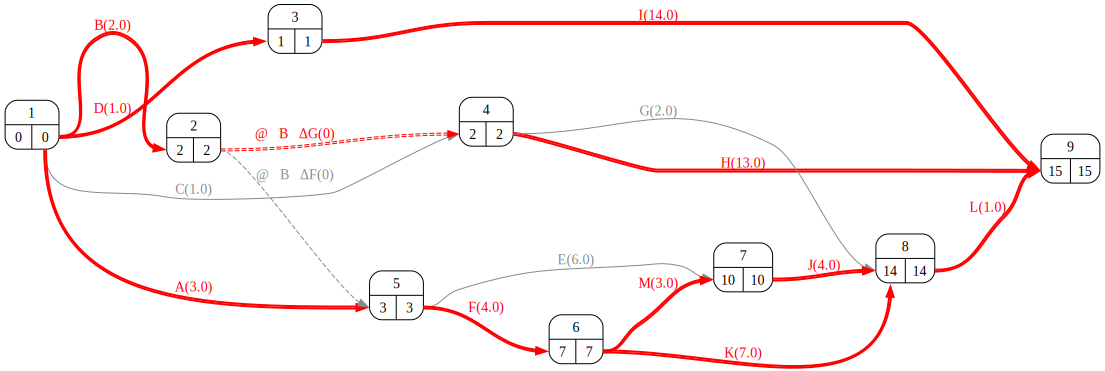

In [19]:
#| fig-cap: "Grafo Pert del proyecto con indicación del camino crítico"
#| label: fig-pertCritico
proyecto.pert(durations=datos_proyecto['duration'], ranksep=1)

Alternativamente, se muestra el grafo roy correspondiente con indicación del camino crítico.

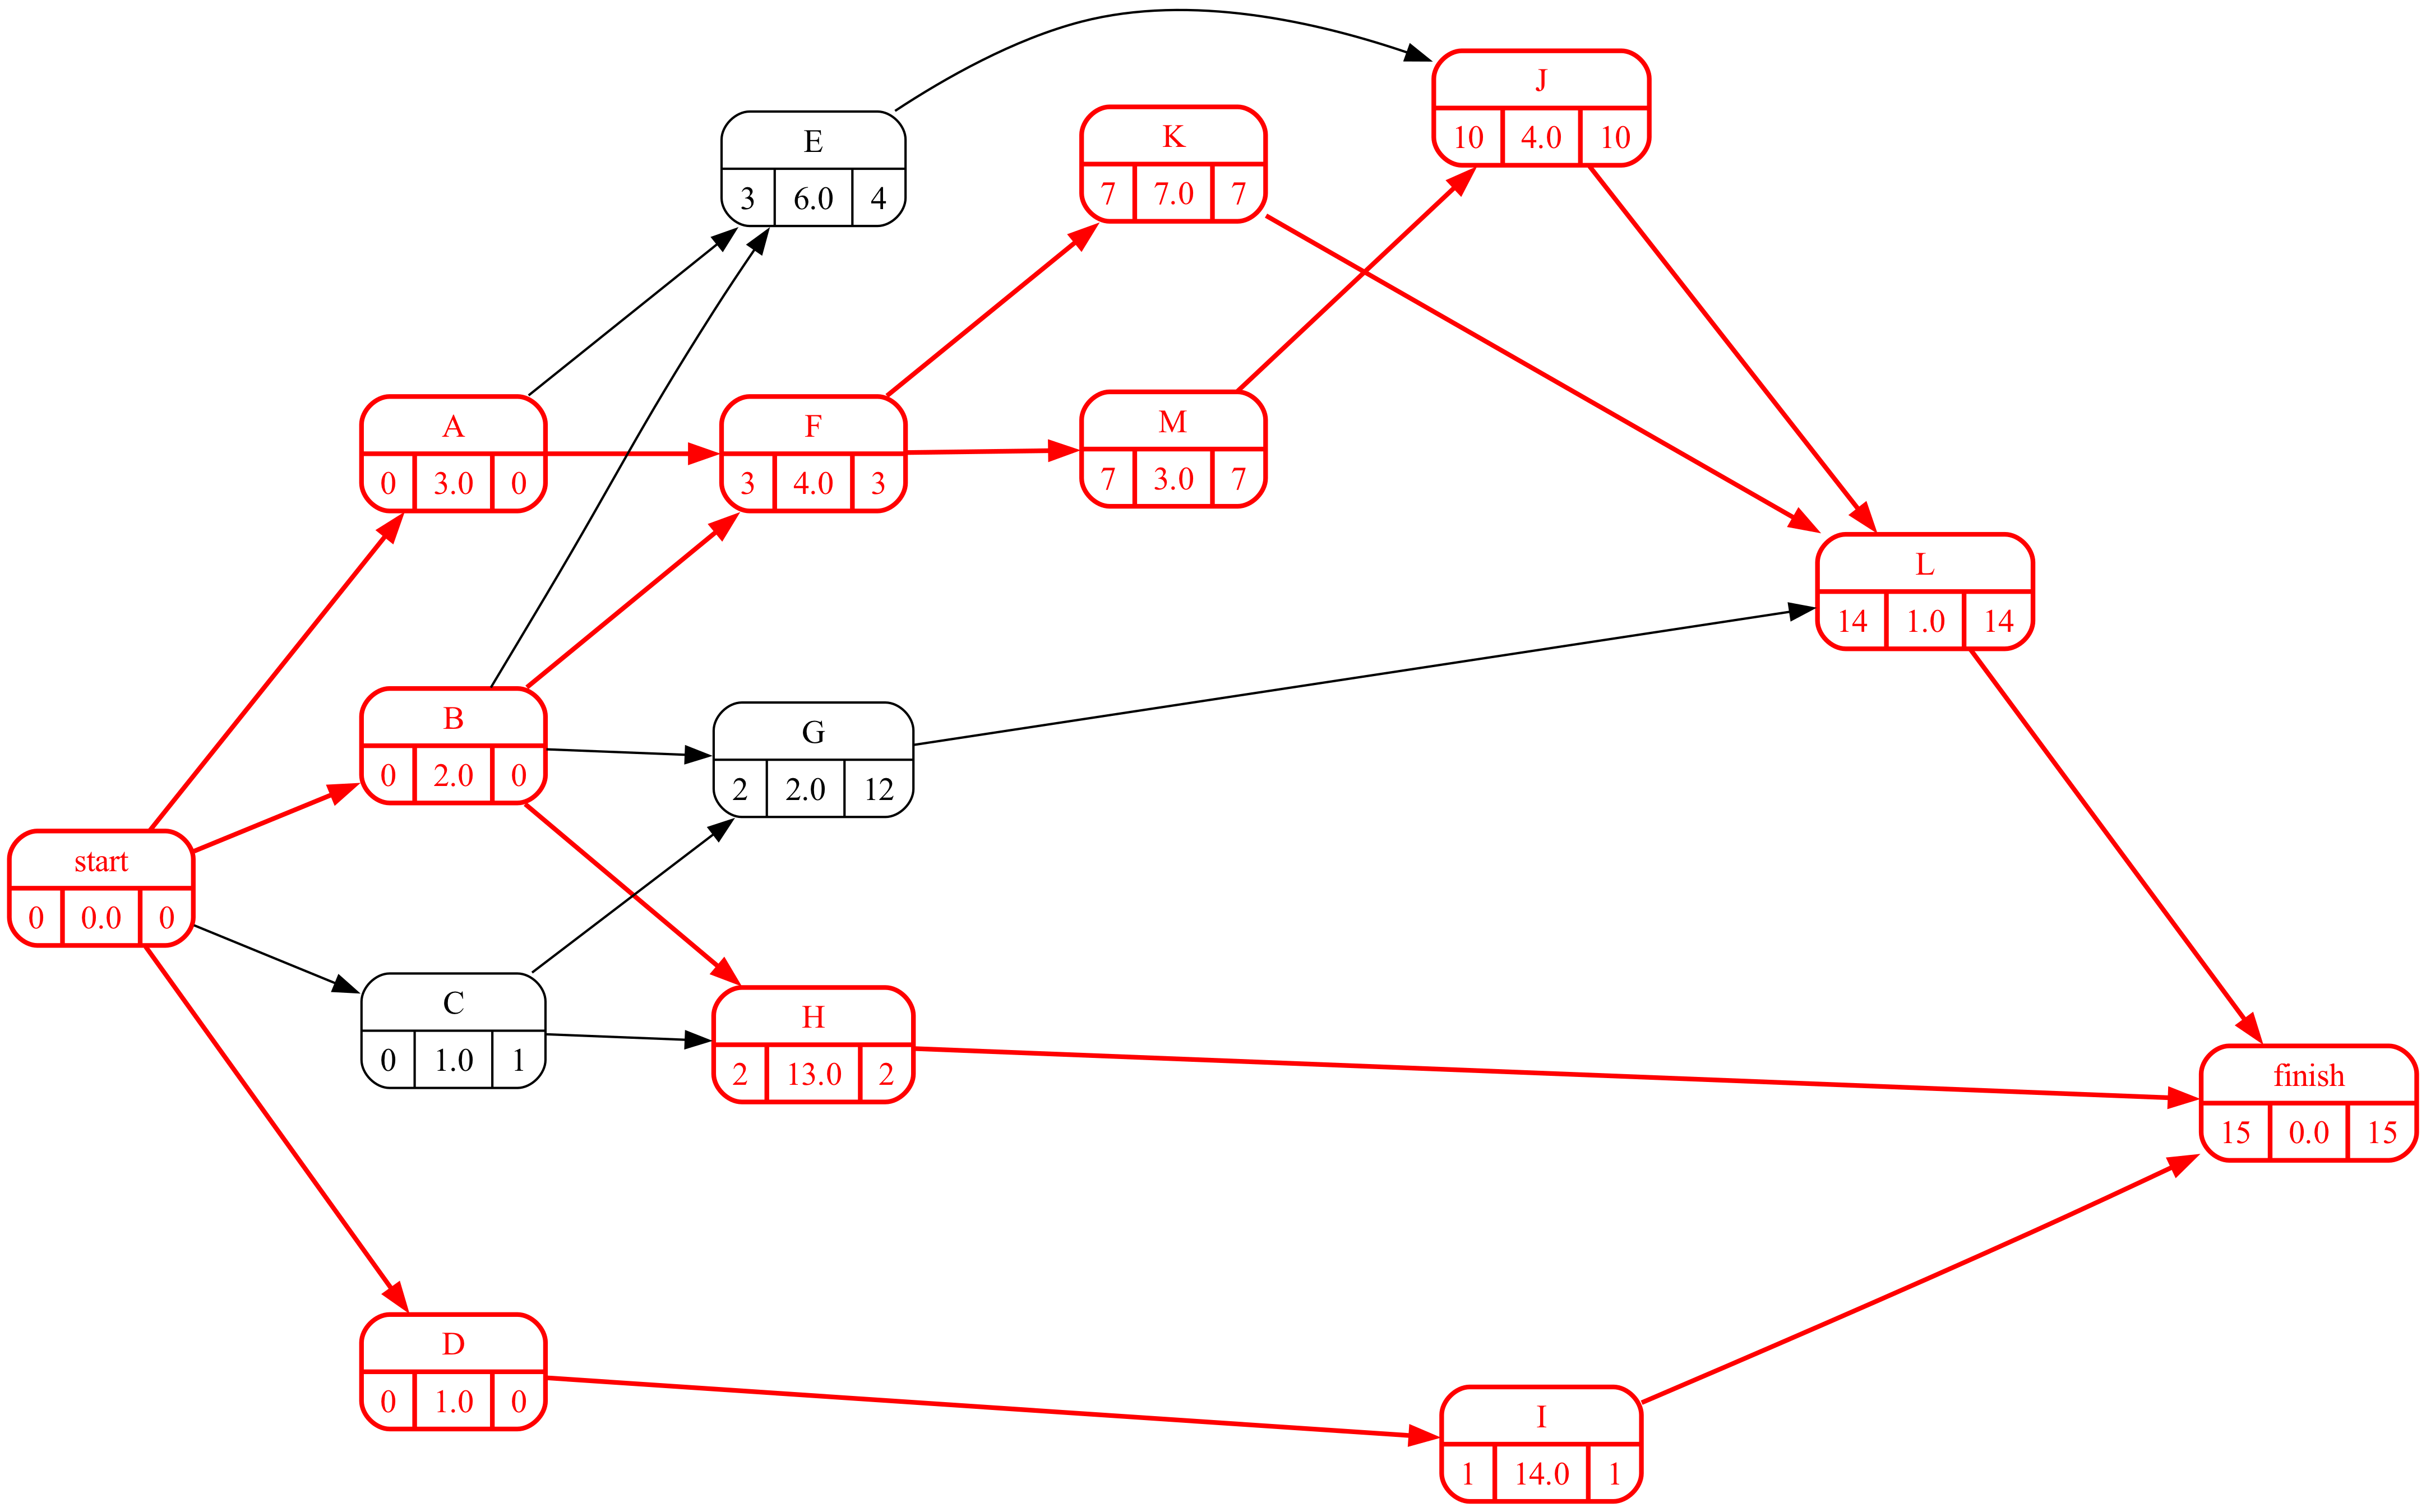

In [20]:
#| fig-cap: "Grafo Roy del proyecto con indicación del camino crítico"
#| label: fig-royCritico
proyecto.roy(durations=datos_proyecto['duration'], ranksep=1, nodesep=1)

## Apartado 2

In [21]:
display(Markdown(pregunta_2))

2.  Indique el coste de realización para duración PERT  

Para responder este apartado tan sólo es necesario sumar los costes indicados en la columna coste_duracion_pert.

In [22]:
Markdown(f"La suma de los costes es {int(datos_proyecto['cost_pert_duration'].sum())}")

La suma de los costes es 21900

{{< pagebreak >}}

## Apartado 3

In [23]:
display(Markdown(pregunta_3))

3.  A la vista de la planificación dada, su jefe le dice que el proyeco tiene que ejecutarse en 12 o menos periodos. ¿Con qué probabilidad estima que se verán cumplidos los deseos de su jefe?  

### Duración media del proyecto

La duración media del proyecto ya la tenemos calculada:

In [24]:
duracion_media_proyecto = int(proyecto.duration(datos_proyecto['duration']))

In [25]:
Markdown(f"La media de la duración del proyecto es {duracion_media_proyecto}")

La media de la duración del proyecto es 15

### Varianza de la duración del proyecto

Se calcula entonces la varianza de cada una de las rutas del camino crítico como suma de las varianzas de las actividades que lo componen. Se indica en color la ruta con máxima varianza, que determina la varianza del proyecto.

In [26]:
datos_proyecto['variance'] = datos_proyecto.eval('standard_deviation ** 2')
desviacion_proyecto, varianza_caminos = proyecto.standard_deviation(durations=datos_proyecto['duration'],
                                                  variances=datos_proyecto['variance'])

In [27]:
#| tbl-cap: "Varianza de las rutas del camino crítico"
#| label: tbl-varianzaRutas
varianza_caminos

,Activities,Variance
Route_2,"A, F, K, L",3.24
Route_3,"A, F, J, L, M",3.24
Route_8,"B, H",5.43
Route_11,"D, I",16.00


In [28]:
Markdown(f"La desviación típica de la duración del proyecto es la raiz cuadrada de su varianza. En este caso la desviación típica tiene valor {round(float(desviacion_proyecto), 2)}")

La desviación típica de la duración del proyecto es la raiz cuadrada de su varianza. En este caso la desviación típica tiene valor 4.0

### Cálculo de la probabilidad

Una vez caracterizada la distribución normal con la que aproximamos la duración del proyecto, podemos hacer el cálculo de la probabilidad:

In [29]:
import scipy
from scipy.stats import norm

probabilidad_de_terminar_antes_de_b = norm.cdf(periodo_probabilidad_b, loc=duracion_media_proyecto, scale=desviacion_proyecto)
probabilidad_de_terminar_antes_de_b  = round(float(probabilidad_de_terminar_antes_de_b * 100), 2)

In [30]:
Markdown(f"La probabilidad pedida es {probabilidad_de_terminar_antes_de_b} por ciento.")

La probabilidad pedida es 22.66 por ciento.

{{< pagebreak >}}

## Apartado 4.

In [31]:
display(Markdown(pregunta_4))

4.  Reduzca la duración del proyecto dos unidades de tiempo con el menor incremento de coste posible.  

Se aborda la solución de este apartado mediante la técnica de reducción de la duración del proyecto con mínimo coste.

In [32]:
ackoff, best_option, durations, available = proyecto.ackoff(durations=datos_proyecto['duration'],
                                                            min_durations=datos_proyecto['cap_duration'],
                                                            costs=datos_proyecto['ucr'],
                                                            reduction=2)

In [33]:
#| tbl-cap: "Cuadro del algoritmo de Ackoff Sasieni"
#| label: tbl-ackoff
ackoff

,A,B,C,D,E,F,G,H,I,J,K,L,M,0,1,2
Route_1,200.0,,,,150.0,,,,,0.0,,,,14.0,13.0,12.0
Route_2,200.0,,,,,66.7,,,,,0.0,,,15.0,14.0,13.0
Route_3,200.0,,,,,66.7,,,,0.0,,,0.0,15.0,14.0,13.0
Route_4,,0.0,,,150.0,,,,,0.0,,,,13.0,11.0,10.0
Route_5,,0.0,,,,66.7,,,,,0.0,,,14.0,12.0,11.0
Route_6,,0.0,,,,66.7,,,,0.0,,,0.0,14.0,12.0,11.0
Route_7,,0.0,,,,,100.0,,,,,,,5.0,4.0,4.0
Route_8,,0.0,,,,,,140.0,,,,,,15.0,14.0,13.0
Route_9,,,,,,,100.0,,,,,,,4.0,4.0,4.0
Route_10,,,,,,,,140.0,,,,,,14.0,14.0,13.0


Las actividades reducidas en cada una de las iteraciones son:

In [34]:
for iteracion, actividades in best_option.items():
    display(Markdown(f"- Iteración {iteracion}: " + ", ".join(actividades) + "<br>"))

- Iteración 0: I, J, B, K<br>

- Iteración 1: I, J, K, H<br>